In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
accepted = pd.read_csv('/Users/ivanpassoni/Google Drive/LendingClub2007-2015/accepted_before_2015.csv')

In [39]:
accepted['issue_d'] = accepted['issue_d'].astype(np.datetime64)
accepted['last_pymnt_d'] = accepted['last_pymnt_d'].astype(np.datetime64)

In [40]:
accepted['duration_days'] = accepted['last_pymnt_d'] - accepted['issue_d']
accepted['duration_days'] = accepted['duration_days'].apply(lambda s: s.days)

In [247]:
accepted['last_pymnt_d'] - accepted['issue_d']

0         609 days
1         548 days
2         121 days
3         243 days
5         517 days
            ...   
465829   1035 days
465830   1096 days
465831   1065 days
465832     91 days
465833   1796 days
Length: 453647, dtype: timedelta64[ns]

In [259]:
def loan_length(d1, d2):
    d1 = pd.to_datetime(d1)
    d2 = pd.to_datetime(d2)
    return (d1.year - d2.year) * 12 + d1.month - d2.month

loan_months = []
for end, start in zip(accepted['last_pymnt_d'], accepted['issue_d']):
    loan_months.append(loan_length(end, start))
    
accepted['duration_months'] = loan_months

In [278]:
# accepted.to_csv('/Users/ivanpassoni/Google Drive/LendingClub2007-2015/accepted_b_2015_clean.csv', index = False)

### Loan count/quantity by group

In [ ]:
# If we want to resize figure
plt.figure(figsize=(12,16))

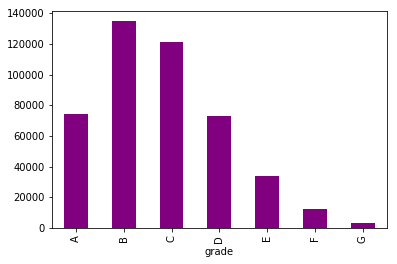

In [265]:
accepted.groupby(['grade']).size().plot(kind ='bar', color ='purple' ) 

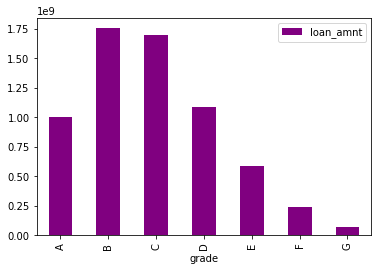

In [267]:
accepted.groupby(['grade']).agg({'loan_amnt':'sum'}).plot(kind ='bar', color ='purple' )

## Status of loan

In [41]:
paid_f = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']
 
current = ['Current', 'Late (16-30 days)', 'In Grace Period']

defaulted = ['Default','Does not meet the credit policy. Status:Charged Off', 'Charged Off', 'Late (31-120 days)']

accepted.drop(
    index = accepted.loc[[True if row in current else False for row in accepted['loan_status']], 'loan_status'].index,
    inplace = True)

accepted['loan_status'] = accepted['loan_status'].apply(lambda s: 'FullyPaid' if s in paid_f else 'Defaulted')

In [268]:
accepted['loan_status'].value_counts()

PaidFull     376150
Defaulted     77497
Name: loan_status, dtype: int64

In [42]:
accepted['loan_status'].value_counts()

status = accepted.groupby("loan_status")[["loan_status"]].count()
status = accepted.groupby("loan_status")[["loan_status"]].count()
status['ratio'] = ((status[['loan_status']]/accepted.shape[0])*100).round(2)

status.sort_values(by=["ratio"], ascending=False)

,loan_status,ratio
loan_status,,
PaidFull,376150,82.92
Defaulted,77497,17.08


### Interest rate by grade/subgrade

In [45]:
#Median interest rate by grade
accepted.groupby(['grade', 'sub_grade']).agg({"int_rate":"median"})

int_rate
grade sub_grade          
A     A1             6.03
      A2             6.62
      A3             7.62
      A4             7.90
      A5             8.90
B     B1             9.67
      B2            10.99
      B3            11.99
      B4            12.49
      B5            12.99
C     C1            13.65
      C2            14.16
      C3            14.64
      C4            15.31
      C5            15.61
D     D1            16.59
      D2            17.57
      D3            18.25
      D4            18.92
      D5            19.47
E     E1            18.99
      E2            20.49
      E3            20.99
      E4            21.98
      E5            22.45
F     F1            23.43
      F2            24.08
      F3            24.50
      F4            24.99
      F5            25.57
G     G1            25.80
      G2            25.83
      G3            25.89
      G4            25.99
      G5            26.06

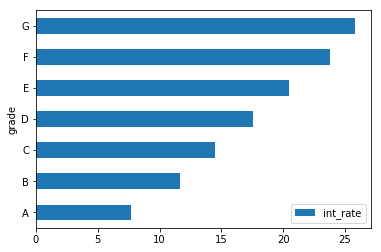

In [47]:
#bar charts for median interest rate by grade
int_r = accepted.groupby(['grade']).agg({"int_rate":"median"})
int_r.plot.barh()

### Percentage of term by grade 

In [155]:
term_by_grade = accepted.groupby(['grade', 'term']).agg({'id':'count'})
term_by_grade.columns = pd.Index(['count'])
count_by_grade = term_by_grade.groupby('grade').agg({'count':'sum'})
count_by_grade.columns = pd.Index(['total_by_grade'])

In [156]:
temp = term_by_grade.index
term_by_grade = term_by_grade.merge(count_by_grade, how = 'left', on = 'grade')
term_by_grade.index = temp

In [164]:
term_by_grade['percentage'] = term_by_grade['count']/term_by_grade['total_by_grade']
term_by_grade.drop(columns = ['count', 'total_by_grade'], inplace = True)
term_by_grade.reset_index(inplace = True)

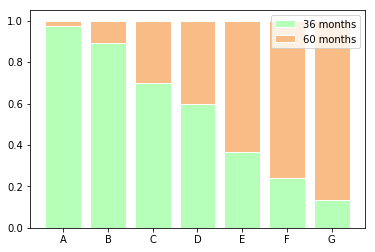

In [208]:
x = ['A','B','C','D','E','F','G']

short_term = term_by_grade.loc[term_by_grade['term'] == ' 36 months', :]
long_term = term_by_grade.loc[term_by_grade['term'] == ' 60 months', :]
# plt.bar(x, term_by_grade['percentage'])
# plt.xticks(rotation=90)

plt.bar(x, short_term['percentage'], color='#b5ffb9', edgecolor='white', label="36 months")

plt.bar(x, long_term['percentage'], bottom=short_term['percentage'], color='#f9bc86', edgecolor='white', label="60 months")
plt.legend()

### Return by grade

In [226]:
accepted['invest_return_per'] = (accepted['total_pymnt'] - accepted['funded_amnt'])/accepted['funded_amnt']
accepted['invest_return'] = accepted['total_pymnt'] - accepted['funded_amnt']

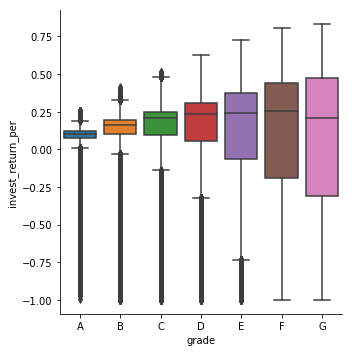

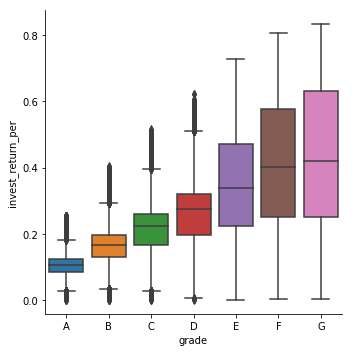

In [239]:
sns.catplot(x='grade', y='invest_return_per', kind="box", data=accepted, order = x)


sns.catplot(x='grade', y='invest_return_per', kind="box", data=accepted.loc[accepted['loan_status'] == 'PaidFull', :], order = x)

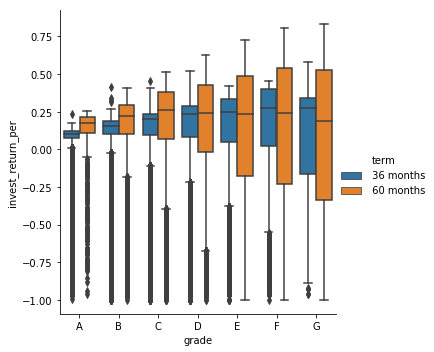

In [241]:
sns.catplot(x='grade', y='invest_return_per', kind='box', hue='term', data=accepted, order=x)

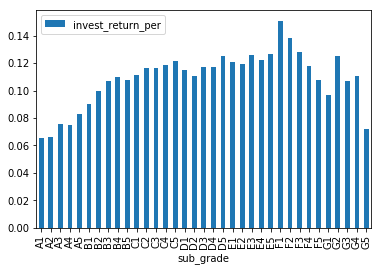

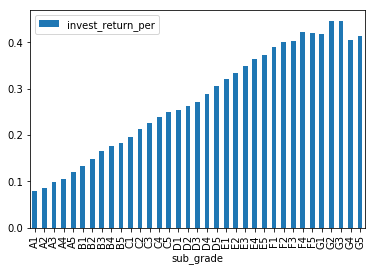

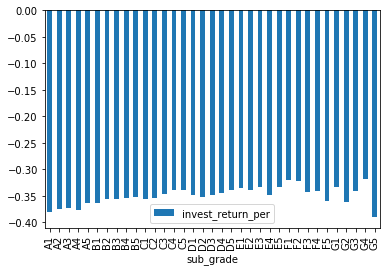

In [273]:
inv_return_total = accepted.groupby(['grade', 'sub_grade']).agg({'invest_return':'mean', 'invest_return_per':'mean'})

inv_return_fully_paid = accepted.loc[accepted['loan_status'] == 'PaidFull', :].groupby(['grade','sub_grade']).agg({'invest_return':'mean', 'invest_return_per':'mean'})

inv_return_fully_default = accepted.loc[accepted['loan_status'] == 'Defaulted', :].groupby(['grade','sub_grade']).agg({'invest_return':'mean', 'invest_return_per':'mean'})

inv_return_total = inv_return_total.reset_index().drop(columns  = 'grade')
inv_return_total.plot.bar(x = 'sub_grade', y = 'invest_return_per')

inv_return_fully_paid = inv_return_fully_paid.reset_index().drop(columns  = 'grade')
inv_return_fully_paid.plot.bar(x = 'sub_grade', y = 'invest_return_per')

inv_return_fully_default = inv_return_fully_default.reset_index().drop(columns  = 'grade')
inv_return_fully_default.plot.bar(x = 'sub_grade', y = 'invest_return_per')

### Survival of loan

In [255]:
survival_days = accepted.groupby(['grade', 'term']).agg({'duration_days':'mean'}).reset_index()

In [256]:
survival_days['term'] = survival_days['term'].apply(lambda s: 1095 if s == ' 36 months' else 5*365)

In [257]:
survival_days

,grade,term,duration_days
0,A,1095,794.082350
1,A,1825,1111.497714
2,B,1095,770.431343
3,B,1825,1027.761885
4,C,1095,736.224938
5,C,1825,972.826170
6,D,1095,715.429776
7,D,1825,891.120647
8,E,1095,692.056145
9,E,1825,853.585663


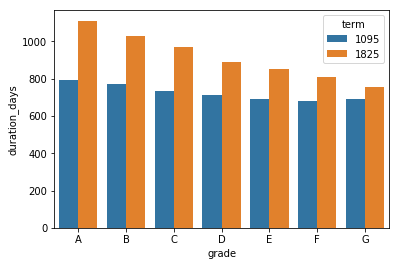

In [258]:
sns.barplot(x = 'grade', y = 'duration_days', hue = 'term', data = survival_days)

In [260]:
survival_months = accepted.groupby(['grade', 'term']).agg({'duration_months':'mean'}).reset_index()

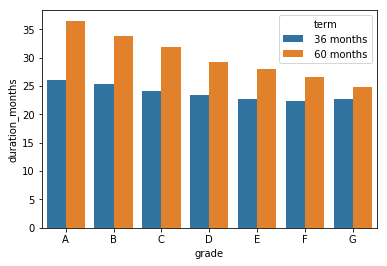

In [262]:
sns.barplot(x = 'grade', y = 'duration_months', hue = 'term', data = survival_months)

### Purpose